In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from datetime import datetime as dt
import matplotlib.pyplot as plt

from scipy.optimize import minimize

# qiskit functions.

from qiskit import QuantumCircuit
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram

In [2]:
sch_data = pd.read_csv("SCH-ZZ-2023-12-08.csv")
sch_data.sample(1)

,ScheduleID,CarrierCode,FlightNumber,AircraftType,AircraftTailNumber,DepartureAirport,ArrivalAirport,DepartureTime,ArrivalTime,StartDate,...,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Frequency_per_week,Frequency,NoOfDepartures,DepartureDates
66,SCH-ZZ-1972995,ZZ,2560.0,Boeing 767,VT-8018,LKO,BLR,21:07,16:35,05/06/2024,...,0,0,0,1,0,0,2,15,13,"['05/09/2024', '05/12/2024', '05/16/2024', '05..."


In [3]:
def time_diff(past_time, forward_time):
    forward_datetime = dt.strptime(forward_time, '%H:%M')
    past_datetime = dt.strptime(past_time, '%H:%M')
    time_difference = forward_datetime - past_datetime
    hours, remainder = divmod(time_difference.seconds, 3600)
    minutes = remainder // 60
    return hours + (minutes/60)

In [4]:
graph_data = []
for i in range(sch_data.shape[0]):
    iden = sch_data['ScheduleID'].iloc[i]
    dep_time = sch_data['DepartureTime'].iloc[i]
    arr_time = sch_data['ArrivalTime'].iloc[i]
    dep_port = sch_data['DepartureAirport'].iloc[i]
    arr_port = sch_data['ArrivalAirport'].iloc[i]
    time = round(time_diff(dep_time, arr_time), 2)
    graph_data.append([iden, dep_port, arr_port, time])

    
graph_data = pd.DataFrame(graph_data, columns = ['ScheduleID', 'DepartureAirport', 'ArrivalAirport', 'Time Taken'])
graph_data

,ScheduleID,DepartureAirport,ArrivalAirport,Time Taken
0,SCH-ZZ-3400127,AMD,HYD,8.63
1,SCH-ZZ-6095474,HYD,AMD,15.73
2,SCH-ZZ-4253453,AMD,MAA,3.13
3,SCH-ZZ-6036812,DEL,AMD,1.52
4,SCH-ZZ-8346723,BLR,HYD,8.17
...,...,...,...,...
85,SCH-ZZ-4235611,GOI,GAU,23.18
86,SCH-ZZ-9059901,GOI,GAU,22.70
87,SCH-ZZ-8267287,PNQ,GOI,9.35
88,SCH-ZZ-2790389,GAU,PNQ,19.28


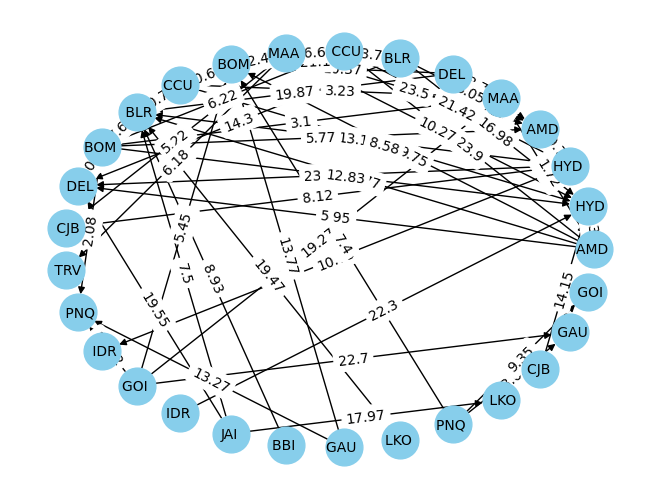

In [5]:
G = nx.DiGraph()

for index, row in graph_data.iterrows():
    G.add_edge(row['DepartureAirport'], row['ArrivalAirport'], weight=row['Time Taken'], schedule_id=row['ScheduleID'])

pos = nx.circular_layout(G) 
labels = nx.get_edge_attributes(G, 'weight')
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10, font_color='black')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show()

In [6]:
# the quantum version

In [7]:
graph_data

,ScheduleID,DepartureAirport,ArrivalAirport,Time Taken
0,SCH-ZZ-3400127,AMD,HYD,8.63
1,SCH-ZZ-6095474,HYD,AMD,15.73
2,SCH-ZZ-4253453,AMD,MAA,3.13
3,SCH-ZZ-6036812,DEL,AMD,1.52
4,SCH-ZZ-8346723,BLR,HYD,8.17
...,...,...,...,...
85,SCH-ZZ-4235611,GOI,GAU,23.18
86,SCH-ZZ-9059901,GOI,GAU,22.70
87,SCH-ZZ-8267287,PNQ,GOI,9.35
88,SCH-ZZ-2790389,GAU,PNQ,19.28


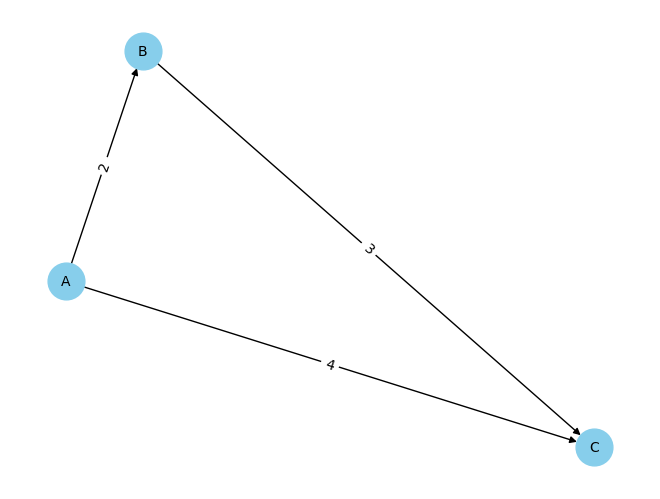

In [8]:
data = {'ScheduleID': [0, 1, 2],
        'DepartureAirport': ['A', 'B', 'A'],
        'ArrivalAirport': ['B', 'C', 'C'],
        'Time Taken': [2, 3, 4]}

graph_data = pd.DataFrame(data, columns=['ScheduleID', 'DepartureAirport', 'ArrivalAirport', 'Time Taken'])

G = nx.DiGraph()

for index, row in graph_data.iterrows():
    G.add_edge(row['DepartureAirport'], row['ArrivalAirport'], weight=row['Time Taken'], schedule_id=row['ScheduleID'])

pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10, font_color='black')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show()

In [9]:
def cost_fn(data, start, end, bitstring):
    bits = [int(ids) for i, ids in enumerate(bitstring) if i < len(data)]
    index = [i for i, value in enumerate(bits) if value == 1]
    selected = data[data['ScheduleID'].isin(index)]
    score = 0
    if len(selected['DepartureAirport'].unique()) == selected['DepartureAirport'].count() and len(selected['ArrivalAirport'].unique()) == selected['ArrivalAirport'].count():
        if start in list(selected['DepartureAirport']) and end in list(selected['ArrivalAirport']):
            score = -data['Time Taken'].sum() + selected['Time Taken'].sum()
    return score

In [10]:
# creates a list of bit strings of length n.
def bin_list(n):
    ans = ['0', '1']
    for _ in range(n - 1):
        ans = ['0' + bit for bit in ans] + ['1' + bit for bit in ans]
    return ans

In [11]:
# basic QAOA function which returns counts.
def qaoa(data, start, end, theta) :
    
    qubits = len(data['ScheduleID'])
    # basic QAOA circuit.
    def qaoa_circ(qubits, theta):
    
        # division of input array Theta.
        nqubits = qubits
        nlayers = len(theta)//3
        beta = theta[:nlayers]
        gamma = theta[nlayers:2*nlayers]
        alpha = theta[2*nlayers:]

        qc = QuantumCircuit(nqubits)

        # initial state.
        qc.h(range(nqubits))

        for layer in range(nlayers):
        
            # problem unitary.
            for pair in range(nqubits-1):
                qc.rzz(2 * gamma[layer], pair, pair+1)
            for qubit in range(nqubits):
                qc.rz(2 * alpha[layer], qubit)
            qc.barrier()
            
            # mixer unitary.
            for qubit in range(nqubits):
                qc.rx(2 * beta[layer], qubit)

        qc.measure_all()
        return qc

    def get_expect_qaoa(data, qubits, start, end, shots=4096):
        backend = Aer.get_backend(simu)
        backend.shots = shots
        start = start
        end = end
        def execute_circ(theta):
            qc = qaoa_circ(qubits, theta)
            counts = backend.run(qc, seed_simulator=seeds, nshots=4096).result().get_counts()
            return expectation(counts, data, start, end)
        return execute_circ
    
    global qc_basic
    qc_basic = qaoa_circ(qubits, theta)
    
    # optimizing parameters for basic QAOA
    expect = get_expect_qaoa(data, qubits, start, end)
    global res_basic
    res_basic = minimize(expect, theta, method='COBYLA')

    backend = Aer.get_backend(simu)
    backend.shots = 4096

    qc_res = qaoa_circ(qubits, res_basic.x)
    counts = backend.run(qc_res, seed_simulator=seeds).result().get_counts()
    return counts

In [12]:
# computes expectation value.
def expectation(counts, data, start, end):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = cost_fn(data, start, end, bitstring)
        avg += obj * count
        sum_count += count
    return avg/sum_count

Basic QAOA :  -2.3408203125


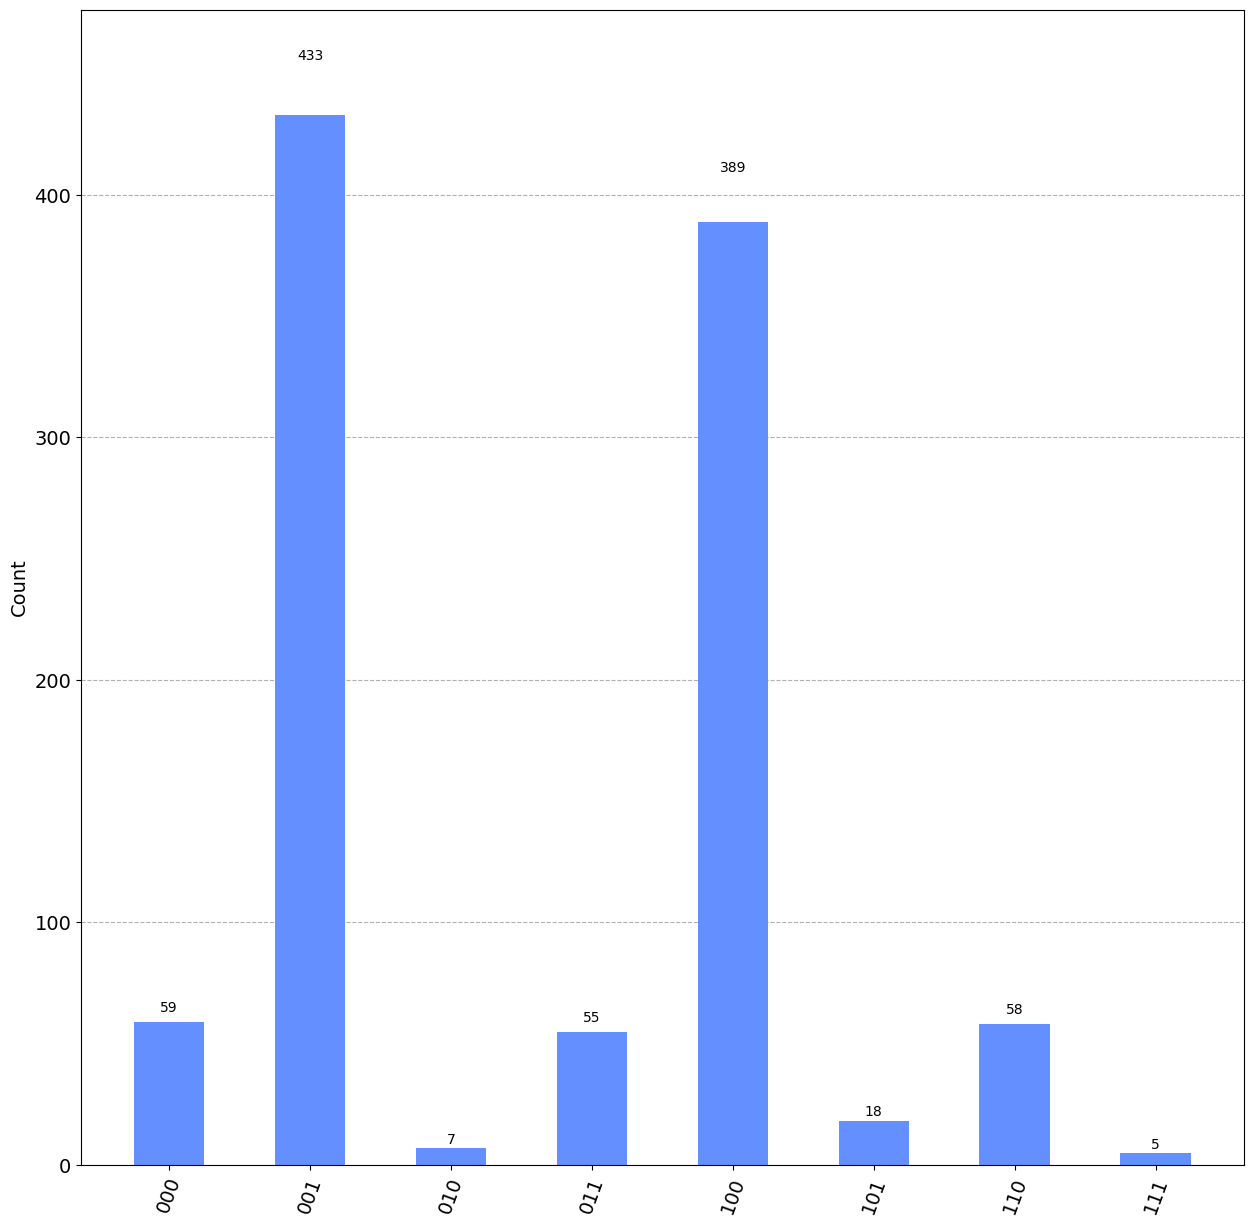

In [16]:
seeds = 15
simu = 'aer_simulator_statevector'

# basic QAOA
layers_b = 3
beta = np.random.rand(layers_b)
gamma = np.random.rand(layers_b)
alpha = np.random.rand(layers_b)
basic = np.concatenate((beta, gamma))

counts = qaoa(graph_data, 'A', 'C', basic)
print("Basic QAOA : ", res_basic.fun)
plot_histogram(counts, figsize = (15,15))